In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [75]:
# set initial properties for data location
data_location = "matrices/"
armatus_location = "./armatus"
out_location = "yielded/"
lines = ["A549_NA_NA_", "HEK293_siRNA-CTCF_NA_", "HEK293_siRNA-Control_NA_", "HepG2_NA_NA_", "RAD21cv-HEK293_HRV-treated_NA_", "RAD21cv-HEK293_TEV-treated_NA_"]
chroms = ["15", "16", "17", "18", "19", "20", "21", "22", "Y"]
repls = [1, 2]
res = 20000
NaN = np.nan
compare_stats = ["JI TADs", "JI boundaries", "OC TADs", "OC boundaries"]
images = "images/"

In [149]:
# set ranges for algorithms
armatus_gamma = [i / 2 for i in range(-10, 11)]
modularity_gamma = list(range(41))
corner_gamma = list(range(11))
ii_cutoff_values = list(range(21))
ii_window_values = [res * i for i in list(np.arange(0.5, 5, 0.5))]
di_cutoff_values = [i for i in range(5, 16)]
di_window_values = [res * i for i in range(1, 5)]
ii_enh_cutoff_values = [i / 10 for i in range(0, 11)]
ii_enh_window_values = [res * i for i in range(1, 5)]

In [28]:
# custom functions
vector_str = np.vectorize(str)

def TAD_bins(arr1, arr2):
    vector_str = np.vectorize(str)
    return npchar.add(vector_str(arr1), npchar.add(",", vector_str(arr2)))

def TAD_boundaries(arr1, arr2):
    return np.unique(np.append(arr1, arr2))

def jaccard_index(arr1, arr2):
    intersection = np.isin(arr1, arr2)
    return sum(intersection) / (arr1.shape[0] + arr2.shape[0] - sum(intersection))

def overlap_coef(arr1, arr2):
    intersection = np.isin(arr1, arr2)
    return sum(intersection) / min(arr1.shape[0], arr2.shape[0])

def size_amount(arr1, arr2):
    return {1: {"size":np.mean(arr1[:, 1] - arr1[:, 0]),
                "amount": arr1.shape[0]
               },
            2: {"size":np.mean(arr2[:, 1] - arr2[:, 0]),
                "amount": arr2.shape[0]
               }
           }

In [5]:
# define other custom functions and dictionary for handling them
def JI_TADs(arr1_1, arr1_2, arr2_1, arr2_2):
    return jaccard_index(TAD_bins(arr1_1, arr1_2), TAD_bins(arr2_1, arr2_2))

def JI_boundaries(arr1_1, arr1_2, arr2_1, arr2_2):
    return jaccard_index(TAD_boundaries(arr1_1, arr1_2), TAD_boundaries(arr2_1, arr2_2))

def OC_TADs(arr1_1, arr1_2, arr2_1, arr2_2):
    return overlap_coef(TAD_bins(arr1_1, arr1_2), TAD_bins(arr2_1, arr2_2))

def OC_boundaries(arr1_1, arr1_2, arr2_1, arr2_2):
    return overlap_coef(TAD_boundaries(arr1_1, arr1_2), TAD_boundaries(arr2_1, arr2_2))

coefs = {"JI TADs": JI_TADs, "JI boundaries": JI_boundaries, "OC TADs": OC_TADs, "OC boundaries": OC_boundaries}

In [63]:
# convert armatus tad coordinates for further handling
for line in lines:
    for repl in repls:
        for chrom in chroms:
            for gamma in armatus_gamma:
                print(f"\rline={line} chrom={chrom} repl={repl} gamma={gamma}     ", end="")
                try:
                    tads = pd.read_csv(f"{out_location}armatus_{line}{repl}.20000.chr{chrom}.{gamma}.consensus.txt", comment = "#", sep = "\t", header=None)
                except pd.io.common.EmptyDataError:
                    with open(f"{out_location}armatus_{line}{repl}.20000.chr{chrom}.gamma{gamma}.txt", "w"):
                        continue
                del tads[0]
                tads[2] = tads[2] + 1
                tads.to_csv(f"{out_location}armatus_{line}{repl}.20000.chr{chrom}.gamma{gamma}.txt", sep="\t", header=None, index=False)
print("\rFinished.                                            ")    

Finished.                                            mma=5.0       


In [6]:
# make region bed files for tadtool
for line in lines:
    for repl in repls:
        for chrom in chroms:
            print(f"\r{line}{repl}.20000.chr{chrom}" + " " * 10, end="")
            matrix = np.loadtxt(f"{data_location}{line}{repl}.20000.chr{chrom}.txt.gz")
            ndim = matrix.shape[0]
            regions = np.empty(shape=(ndim, 3), dtype="object")
            regions[:, 0] = chrom
            starts = np.array([i * res for i in range(ndim)], dtype="int")
            regions[:, 1] = starts
            regions[:, 2] = starts + res
            np.savetxt(f"{data_location}{line}{repl}.20000.chr{chrom}.bed", regions, delimiter="\t", fmt="%s")

RAD21cv-HEK293_TEV-treated_NA_2.2000.chrY           

lavaburst armatus RAD21cv-HEK293_TEV-treated_NA_ Y       

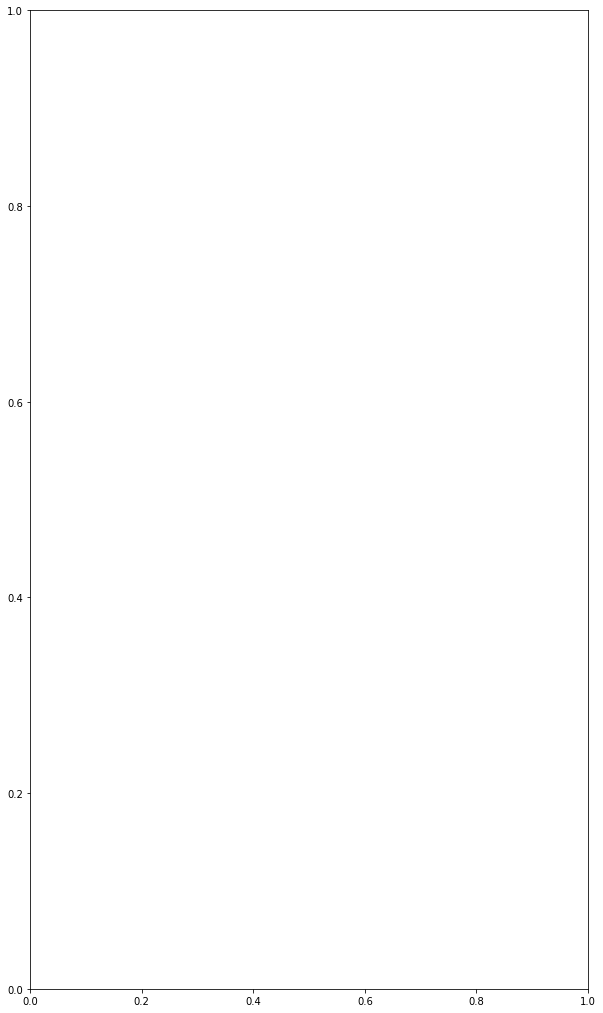

In [66]:
# Inspect initial results for lavaburst armatus
lava_armatus_stats = pd.DataFrame(index=range(len(chroms) * len(armatus_gamma) * len(repls) * len(compare_stats)), columns=["repl", "chrom", "gamma", "value", "stat", "tad_size", "amount"])
index = 0
for line in lines:
    for chrom in chroms:
        for gamma in armatus_gamma:
            print(f"\rlavaburst armatus {line} {chrom}      ", end="")
            empty_1, empty_2 = False, False
            repl_1 = np.loadtxt(f"{out_location}lava_armatus_{line}{1}.20000.chr{chrom}.gamma{gamma}.txt", ndmin=2)
            repl_2 = np.loadtxt(f"{out_location}lava_armatus_{line}{2}.20000.chr{chrom}.gamma{gamma}.txt", ndmin=2)
            
            if repl_1.shape[0] == 0:
                for stat in compare_stats:
                    lava_armatus_stats.loc[index, :] = [1, chrom, gamma, 0, stat, 0, 0]
                    index += 1
                empty_1 = True
                
            if repl_2.shape[0] == 0:
                for stat in compare_stats:
                    lava_armatus_stats.loc[index, :] = [2, chrom, gamma, 0, stat, 0, 0]
                    index += 1
                empty_2 = True
                
            if empty_1 * empty_2:
                continue
                
            elif empty_1:
                size_2 = np.median(repl_2[:, 1] - repl_2[:, 0])
                for stat in compare_stats:
                    lava_armatus_stats.loc[index, :] = [2, chrom, gamma, 0, stat, size_2, repl_2.shape[0]]
                    index += 1
                continue
                
            elif empty_2:
                size_1 = np.median(repl_1[:, 1] - repl_1[:, 0])
                for stat in compare_stats:
                    lava_armatus_stats.loc[index, :] = [1, chrom, gamma, 0, stat, size_1, repl_1.shape[0]]
                    index += 1
                continue
                
            coordinates = (repl_1[:, 0], repl_1[:, 1], repl_2[:, 0], repl_2[:, 1])
            size_amo = size_amount(repl_1, repl_2)
            for repl in repls:
                for stat in compare_stats:
                    lava_armatus_stats.loc[index, :] = [repl, chrom, gamma, coefs[stat](*coordinates), stat, size_amo[repl]["size"], size_amo[repl]["amount"]]
                    index += 1
                    
    mpl.rcParams['figure.figsize'] = [10, 18]        
    sns.set_palette(sns.color_palette("deep"))
    plt.subplot(311)
    sns.pointplot(data=lava_armatus_stats, x="gamma", y="value", hue="stat")
    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
    plt.title(f"Armatus lavaburst: stats for {line} line.")
    plt.subplot(312)
    sns.pointplot(data=lava_armatus_stats, x="gamma", y="tad_size", hue="repl")
    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
    plt.title(f"Armatus lavaburst: mean TAD sizes for {line} line in two replica.")
    plt.ylim(0, 1000000)
    plt.subplot(313)
    sns.pointplot(data=lava_armatus_stats, x="gamma", y="amount", hue="repl")
    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
    plt.title(f"Armatus lavaburst: amount of TADs for {line} line in two replica.")
    plt.savefig(f"{images}lava_armatus_{line}initial.png", bbox_inches='tight')
    plt.clf()
    plt.cla()

In [168]:
# Inspect initial results for armatus standalone
armatus_stats = pd.DataFrame(index=range(len(chroms) * len(armatus_gamma) * len(repls) * len(compare_stats)), columns=["repl", "chrom", "gamma", "value", "stat", "tad_size", "amount"])
index = 0
for line in lines:
    for chrom in chroms:
        for gamma in armatus_gamma:
            print(f"\rarmatus {line} {chrom}      ", end="")
            empty_1, empty_2 = False, False
            repl_1 = np.loadtxt(f"{out_location}armatus_{line}{1}.20000.chr{chrom}.gamma{gamma}.txt", ndmin=2)
            repl_2 = np.loadtxt(f"{out_location}armatus_{line}{2}.20000.chr{chrom}.gamma{gamma}.txt", ndmin=2)
            
            if repl_1.shape[0] == 0:
                for stat in compare_stats:
                    armatus_stats.loc[index, :] = [1, chrom, gamma, 0, stat, 0, 0]
                    index += 1
                empty_1 = True
                
            if repl_2.shape[0] == 0:
                for stat in compare_stats:
                    armatus_stats.loc[index, :] = [2, chrom, gamma, 0, stat, 0, 0]
                    index += 1
                empty_2 = True
                
            if empty_1 * empty_2:
                continue
                
            elif empty_1:
                size_2 = np.median(repl_2[:, 1] - repl_2[:, 0])
                for stat in compare_stats:
                    armatus_stats.loc[index, :] = [2, chrom, gamma, 0, stat, size_2, repl_2.shape[0]]
                    index += 1
                continue
                
            elif empty_2:
                size_1 = np.median(repl_1[:, 1] - repl_1[:, 0])
                for stat in compare_stats:
                    armatus_stats.loc[index, :] = [1, chrom, gamma, 0, stat, size_1, repl_1.shape[0]]
                    index += 1
                continue
                
            coordinates = (repl_1[:, 0], repl_1[:, 1], repl_2[:, 0], repl_2[:, 1])
            size_amo = size_amount(repl_1, repl_2)
            for repl in repls:
                for stat in compare_stats:
                    armatus_stats.loc[index, :] = [repl, chrom, gamma, coefs[stat](*coordinates), stat, size_amo[repl]["size"], size_amo[repl]["amount"]]
                    index += 1
                    
mpl.rcParams['figure.figsize'] = [10, 18]        
    sns.set_palette(sns.color_palette("deep"))
    plt.subplot(311)
    sns.pointplot(data=armatus_stats, x="gamma", y="value", hue="stat")
    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
    plt.title(f"Armatus standalone: stats for {line} line.")
    plt.subplot(312)
    sns.pointplot(data=armatus_stats, x="gamma", y="tad_size", hue="repl")
    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
    plt.title(f"Armatus standalone: mean TAD sizes for {line} line in two replica.")
    plt.ylim(0, 1000000)
    plt.subplot(313)
    sns.pointplot(data=armatus_stats, x="gamma", y="amount", hue="repl")
    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
    plt.title(f"Armatus standalone: amount of TADs for {line} line in two replica.")
    plt.savefig(f"{images}armatus_{line}initial.png", bbox_inches='tight')
    plt.clf()
    plt.cla()

armatus RAD21cv-HEK293_TEV-treated_NA_ Y       

'    mpl.rcParams[\'figure.figsize\'] = [10, 18]        \n    sns.set_palette(sns.color_palette("deep"))\n    plt.subplot(311)\n    sns.pointplot(data=armatus_stats, x="gamma", y="value", hue="stat")\n    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")\n    plt.title(f"Armatus standalone: stats for {line} line.")\n    plt.subplot(312)\n    sns.pointplot(data=armatus_stats, x="gamma", y="tad_size", hue="repl")\n    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")\n    plt.title(f"Armatus standalone: mean TAD sizes for {line} line in two replica.")\n    plt.ylim(0, 1000000)\n    plt.subplot(313)\n    sns.pointplot(data=armatus_stats, x="gamma", y="amount", hue="repl")\n    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")\n    plt.title(f"Armatus standalone: amount of TADs for {line} line in two replica.")\n    plt.savefig(f"{images}armatus_{line}initial.png", bbox_inches=\'tight\')\n    plt.clf()\n    plt.cla()'

modularity RAD21cv-HEK293_TEV-treated_NA_ Y       

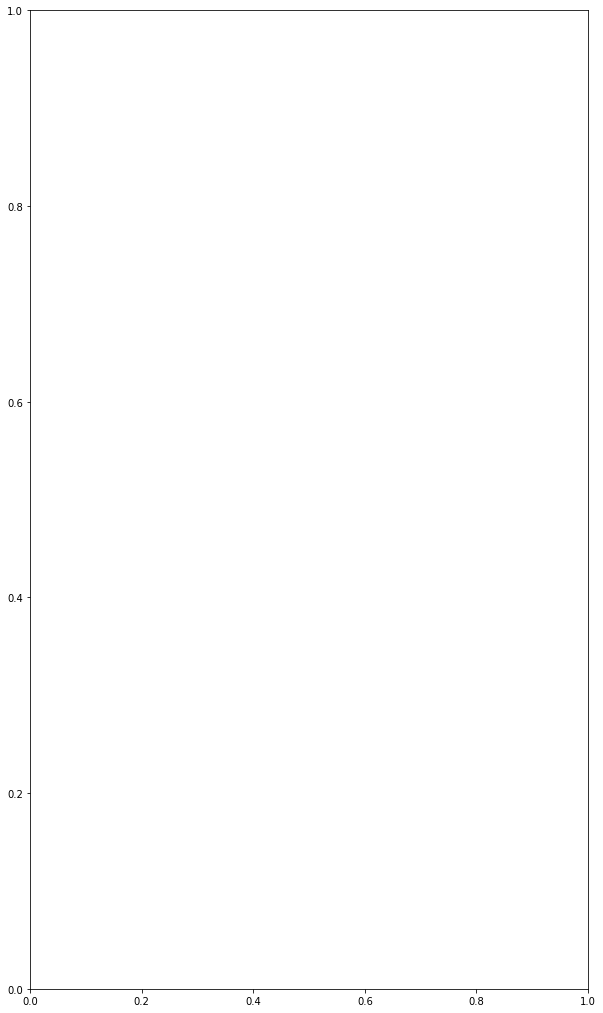

In [71]:
# Inspect initial results for modularity lavaburst
modularity_stats = pd.DataFrame(index=range(len(chroms) * len(modularity_gamma) * len(repls) * len(compare_stats)), columns=["repl", "chrom", "gamma", "value", "stat", "tad_size", "amount"])
index = 0
for line in lines:
    for chrom in chroms:
        for gamma in modularity_gamma:
            print(f"\rmodularity {line} {chrom}      ", end="")
            empty_1, empty_2 = False, False
            repl_1 = np.loadtxt(f"{out_location}lava_modularity_{line}{1}.20000.chr{chrom}.gamma{gamma}.txt", ndmin=2)
            repl_2 = np.loadtxt(f"{out_location}lava_modularity_{line}{2}.20000.chr{chrom}.gamma{gamma}.txt", ndmin=2)
            
            if repl_1.shape[0] == 0:
                for stat in compare_stats:
                    modularity_stats.loc[index, :] = [1, chrom, gamma, 0, stat, 0, 0]
                    index += 1
                empty_1 = True
                
            if repl_2.shape[0] == 0:
                for stat in compare_stats:
                    modularity_stats.loc[index, :] = [2, chrom, gamma, 0, stat, 0, 0]
                    index += 1
                empty_2 = True
                
            if empty_1 * empty_2:
                continue
                
            elif empty_1:
                size_2 = np.median(repl_2[:, 1] - repl_2[:, 0])
                for stat in compare_stats:
                    modularity_stats.loc[index, :] = [2, chrom, gamma, 0, stat, size_2, repl_2.shape[0]]
                    index += 1
                continue
                
            elif empty_2:
                size_1 = np.median(repl_1[:, 1] - repl_1[:, 0])
                for stat in compare_stats:
                    modularity_stats.loc[index, :] = [1, chrom, gamma, 0, stat, size_1, repl_1.shape[0]]
                    index += 1
                continue
                
            coordinates = (repl_1[:, 0], repl_1[:, 1], repl_2[:, 0], repl_2[:, 1])
            size_amo = size_amount(repl_1, repl_2)
            for repl in repls:
                for stat in compare_stats:
                    modularity_stats.loc[index, :] = [repl, chrom, gamma, coefs[stat](*coordinates), stat, size_amo[repl]["size"], size_amo[repl]["amount"]]
                    index += 1
                    
    mpl.rcParams['figure.figsize'] = [10, 18]        
    sns.set_palette(sns.color_palette("deep"))
    plt.subplot(311)
    sns.pointplot(data=modularity_stats, x="gamma", y="value", hue="stat")
    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
    plt.title(f"Modularity: stats for {line} line.")
    plt.subplot(312)
    sns.pointplot(data=modularity_stats, x="gamma", y="tad_size", hue="repl")
    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
    plt.title(f"Modularity: mean TAD sizes for {line} line in two replica.")
    plt.ylim(0, 1000000)
    plt.subplot(313)
    sns.pointplot(data=modularity_stats, x="gamma", y="amount", hue="repl")
    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
    plt.title(f"Modularity: amount of TADs for {line} line in two replica.")
    plt.savefig(f"{images}lava_modularity_{line}initial.png", bbox_inches='tight')
    plt.clf()
    plt.cla()

modularity RAD21cv-HEK293_TEV-treated_NA_ Y       

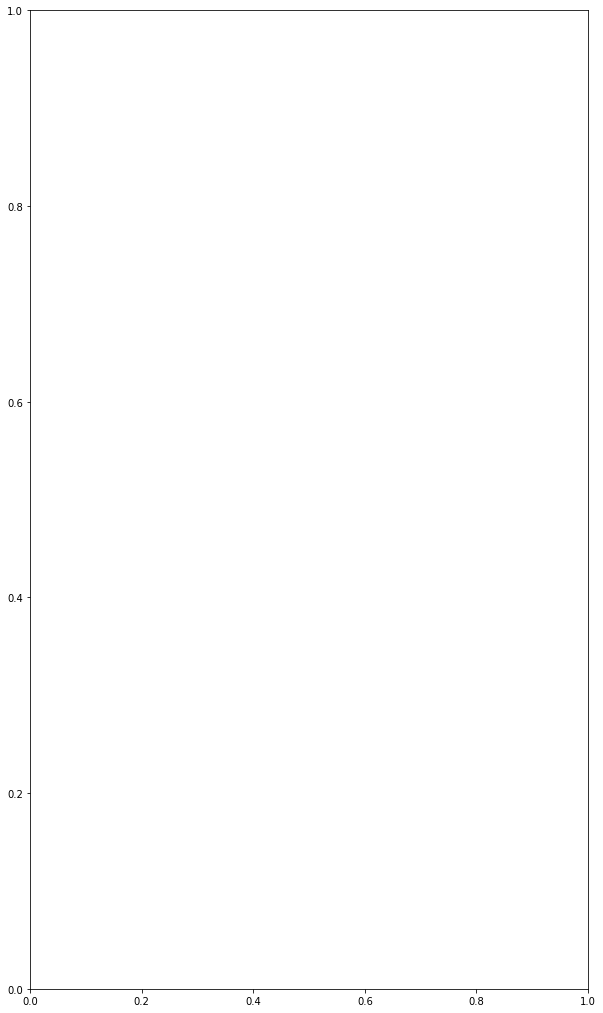

In [72]:
# Inspect initial results for corner lavaburst
corner_stats = pd.DataFrame(index=range(len(chroms) * len(corner_gamma) * len(repls) * len(compare_stats)), columns=["repl", "chrom", "gamma", "value", "stat", "tad_size", "amount"])
index = 0
for line in lines:
    for chrom in chroms:
        for gamma in corner_gamma:
            print(f"\rcorner {line} {chrom}      ", end="")
            empty_1, empty_2 = False, False
            repl_1 = np.loadtxt(f"{out_location}lava_corner_{line}{1}.20000.chr{chrom}.gamma{gamma}.txt", ndmin=2)
            repl_2 = np.loadtxt(f"{out_location}lava_corner_{line}{2}.20000.chr{chrom}.gamma{gamma}.txt", ndmin=2)
            
            if repl_1.shape[0] == 0:
                for stat in compare_stats:
                    corner_stats.loc[index, :] = [1, chrom, gamma, 0, stat, 0, 0]
                    index += 1
                empty_1 = True
                
            if repl_2.shape[0] == 0:
                for stat in compare_stats:
                    corner_stats.loc[index, :] = [2, chrom, gamma, 0, stat, 0, 0]
                    index += 1
                empty_2 = True
                
            if empty_1 * empty_2:
                continue
                
            elif empty_1:
                size_2 = np.median(repl_2[:, 1] - repl_2[:, 0])
                for stat in compare_stats:
                    corner_stats.loc[index, :] = [2, chrom, gamma, 0, stat, size_2, repl_2.shape[0]]
                    index += 1
                continue
                
            elif empty_2:
                size_1 = np.median(repl_1[:, 1] - repl_1[:, 0])
                for stat in compare_stats:
                    corner_stats.loc[index, :] = [1, chrom, gamma, 0, stat, size_1, repl_1.shape[0]]
                    index += 1
                continue
                
            coordinates = (repl_1[:, 0], repl_1[:, 1], repl_2[:, 0], repl_2[:, 1])
            size_amo = size_amount(repl_1, repl_2)
            for repl in repls:
                for stat in compare_stats:
                    corner_stats.loc[index, :] = [repl, chrom, gamma, coefs[stat](*coordinates), stat, size_amo[repl]["size"], size_amo[repl]["amount"]]
                    index += 1
                    
    mpl.rcParams['figure.figsize'] = [10, 18]        
    sns.set_palette(sns.color_palette("deep"))
    plt.subplot(311)
    sns.pointplot(data=corner_stats, x="gamma", y="value", hue="stat")
    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
    plt.title(f"Corner: stats for {line} line.")
    plt.subplot(312)
    sns.pointplot(data=corner_stats, x="gamma", y="tad_size", hue="repl")
    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
    plt.title(f"Corner: mean TAD sizes for {line} line in two replica.")
    plt.ylim(0, 1000000)
    plt.subplot(313)
    sns.pointplot(data=corner_stats, x="gamma", y="amount", hue="repl")
    plt.legend(bbox_to_anchor=(1.04,0), loc="lower left")
    plt.title(f"Corner: amount of TADs for {line} line in two replica.")
    plt.savefig(f"{images}lava_corner_{line}initial.png", bbox_inches='tight')
    plt.clf()
    plt.cla()

ii_enh HEK293_siRNA-CTCF_NA_ Y       

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_2.20000.chrY_window80000_cutoff0.4.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_2.20000.chrY_window60000_cutoff0.5.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh HEK293_siRNA-CTCF_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_2.20000.chrY_window80000_cutoff0.5.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_1.20000.chrY_window60000_cutoff0.6.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_2.20000.chrY_window60000_cutoff0.6.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh HEK293_siRNA-CTCF_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_1.20000.chrY_window80000_cutoff0.6.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_2.20000.chrY_window80000_cutoff0.6.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_1.20000.chrY_window60000_cutoff0.7.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_2.20000.chrY_window60000_cutoff0.7.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh HEK293_siRNA-CTCF_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_1.20000.chrY_window80000_cutoff0.7.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_2.20000.chrY_window80000_cutoff0.7.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_2.20000.chrY_window40000_cutoff0.8.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_1.20000.chrY_window60000_cutoff0.8.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\li

ii_enh HEK293_siRNA-CTCF_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_1.20000.chrY_window80000_cutoff0.8.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_2.20000.chrY_window80000_cutoff0.8.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_2.20000.chrY_window40000_cutoff0.9.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_1.20000.chrY_window60000_cutoff0.9.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\li

ii_enh HEK293_siRNA-CTCF_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_1.20000.chrY_window80000_cutoff0.9.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_2.20000.chrY_window80000_cutoff0.9.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_2.20000.chrY_window40000_cutoff1.0.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_1.20000.chrY_window60000_cutoff1.0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\li

ii_enh HEK293_siRNA-CTCF_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_1.20000.chrY_window80000_cutoff1.0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-CTCF_NA_2.20000.chrY_window80000_cutoff1.0.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh HEK293_siRNA-Control_NA_ Y       

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff0.2.txt"
  # Remove the CWD from sys.path while we load stuff.


ii_enh HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff0.3.txt"
  # Remove the CWD from sys.path while we load stuff.


ii_enh HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutoff0.4.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff0.4.txt"
  # Remove the CWD from sys.path while we load stuff.


ii_enh HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutoff0.5.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff0.5.txt"
  # Remove the CWD from sys.path while we load stuff.


ii_enh HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window40000_cutoff0.6.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutoff0.6.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff0.6.txt"
  # Remove the CWD from sys.path while we load stuff.


ii_enh HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window40000_cutoff0.7.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutoff0.7.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff0.7.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_2.20000.chrY_window80000_cutoff0.7.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window40000_cutoff0.8.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutoff0.8.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff0.8.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_2.20000.chrY_window80000_cutoff0.8.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window40000_cutoff0.9.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutoff0.9.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff0.9.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_2.20000.chrY_window80000_cutoff0.9.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window40000_cutoff1.0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutoff1.0.txt"
  # Remove the CWD from sys.path while we load stuff.


ii_enh HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff1.0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HEK293_siRNA-Control_NA_2.20000.chrY_window80000_cutoff1.0.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh HepG2_NA_NA_ 19      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HepG2_NA_NA_1.20000.chr19_window80000_cutoff0.1.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HepG2_NA_NA_2.20000.chr19_window80000_cutoff0.1.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh HepG2_NA_NA_ 19      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HepG2_NA_NA_1.20000.chr19_window80000_cutoff0.2.txt"
  # Remove the CWD from sys.path while we load stuff.


ii_enh HepG2_NA_NA_ 19      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HepG2_NA_NA_1.20000.chr19_window80000_cutoff0.3.txt"
  # Remove the CWD from sys.path while we load stuff.


ii_enh HepG2_NA_NA_ 19      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HepG2_NA_NA_1.20000.chr19_window80000_cutoff0.4.txt"
  # Remove the CWD from sys.path while we load stuff.


ii_enh HepG2_NA_NA_ 19      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HepG2_NA_NA_1.20000.chr19_window80000_cutoff0.5.txt"
  # Remove the CWD from sys.path while we load stuff.


ii_enh HepG2_NA_NA_ 19      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HepG2_NA_NA_1.20000.chr19_window80000_cutoff0.6.txt"
  # Remove the CWD from sys.path while we load stuff.


ii_enh HepG2_NA_NA_ 19      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HepG2_NA_NA_1.20000.chr19_window80000_cutoff0.7.txt"
  # Remove the CWD from sys.path while we load stuff.


ii_enh HepG2_NA_NA_ 19      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_HepG2_NA_NA_1.20000.chr19_window80000_cutoff0.8.txt"
  # Remove the CWD from sys.path while we load stuff.


ii_enh RAD21cv-HEK293_HRV-treated_NA_ Y       

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window60000_cutoff0.4.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff0.4.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window80000_cutoff0.4.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window80000_cutoff0.4.txt"
  # This is added back by InteractiveShellApp.init

ii_enh RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window60000_cutoff0.5.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff0.5.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window80000_cutoff0.5.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window80000_cutoff0.5.txt"
  # This is added back by InteractiveShellApp.init

ii_enh RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window40000_cutoff0.6.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window60000_cutoff0.6.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff0.6.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window80000_cutoff0.6.txt"
  # Remove the CWD from sys.path while we load

ii_enh RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window40000_cutoff0.7.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window60000_cutoff0.7.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff0.7.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window80000_cutoff0.7.txt"
  # Remove the CWD from sys.path while we load

ii_enh RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window40000_cutoff0.8.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window40000_cutoff0.8.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window60000_cutoff0.8.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff0.8.txt"
  # This is added back by InteractiveShellApp.init

ii_enh RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window80000_cutoff0.8.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window80000_cutoff0.8.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window40000_cutoff0.9.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window40000_cutoff0.9.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window60000_cutoff0.9.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff0.9.txt"
  # This is added back by InteractiveShellApp.init

ii_enh RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window80000_cutoff0.9.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window80000_cutoff0.9.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window40000_cutoff1.0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window40000_cutoff1.0.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window60000_cutoff1.0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff1.0.txt"
  # This is added back by InteractiveShellApp.init

ii_enh RAD21cv-HEK293_TEV-treated_NA_ Y       

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window60000_cutoff0.2.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff0.2.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window40000_cutoff0.3.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window60000_cutoff0.3.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff0.3.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff0.3.txt"
  # This is added back by InteractiveShellApp.

ii_enh RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window40000_cutoff0.4.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window60000_cutoff0.4.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window60000_cutoff0.4.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff0.4.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff0.4.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window40000_cutoff0.5.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window60000_cutoff0.5.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window60000_cutoff0.5.txt"
  # This is added back by InteractiveShellApp.init_path()


ii_enh RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff0.5.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff0.5.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window40000_cutoff0.6.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window40000_cutoff0.6.txt"
  # This is added back by InteractiveShellApp.init

ii_enh RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window60000_cutoff0.6.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window60000_cutoff0.6.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff0.6.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff0.6.txt"
  # This is added back by InteractiveShellApp.init

ii_enh RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window40000_cutoff0.7.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window40000_cutoff0.7.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window60000_cutoff0.7.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window60000_cutoff0.7.txt"
  # This is added back by InteractiveShellApp.init

ii_enh RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window40000_cutoff0.8.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window40000_cutoff0.8.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window60000_cutoff0.8.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window60000_cutoff0.8.txt"
  # This is added back by InteractiveShellApp.init

ii_enh RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff0.8.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff0.8.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window40000_cutoff0.9.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window40000_cutoff0.9.txt"
  # This is added back by InteractiveShellApp.init

ii_enh RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window60000_cutoff0.9.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window60000_cutoff0.9.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff0.9.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff0.9.txt"
  # This is added back by InteractiveShellApp.init

ii_enh RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window40000_cutoff1.0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window40000_cutoff1.0.txt"
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window60000_cutoff1.0.txt"
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window60000_cutoff1.0.txt"
  # This is added back by InteractiveShellApp.init

ii_enh RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: loadtxt: Empty input file: "yielded/ii_enh_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff1.0.txt"
  # This is added back by InteractiveShellApp.init_path()


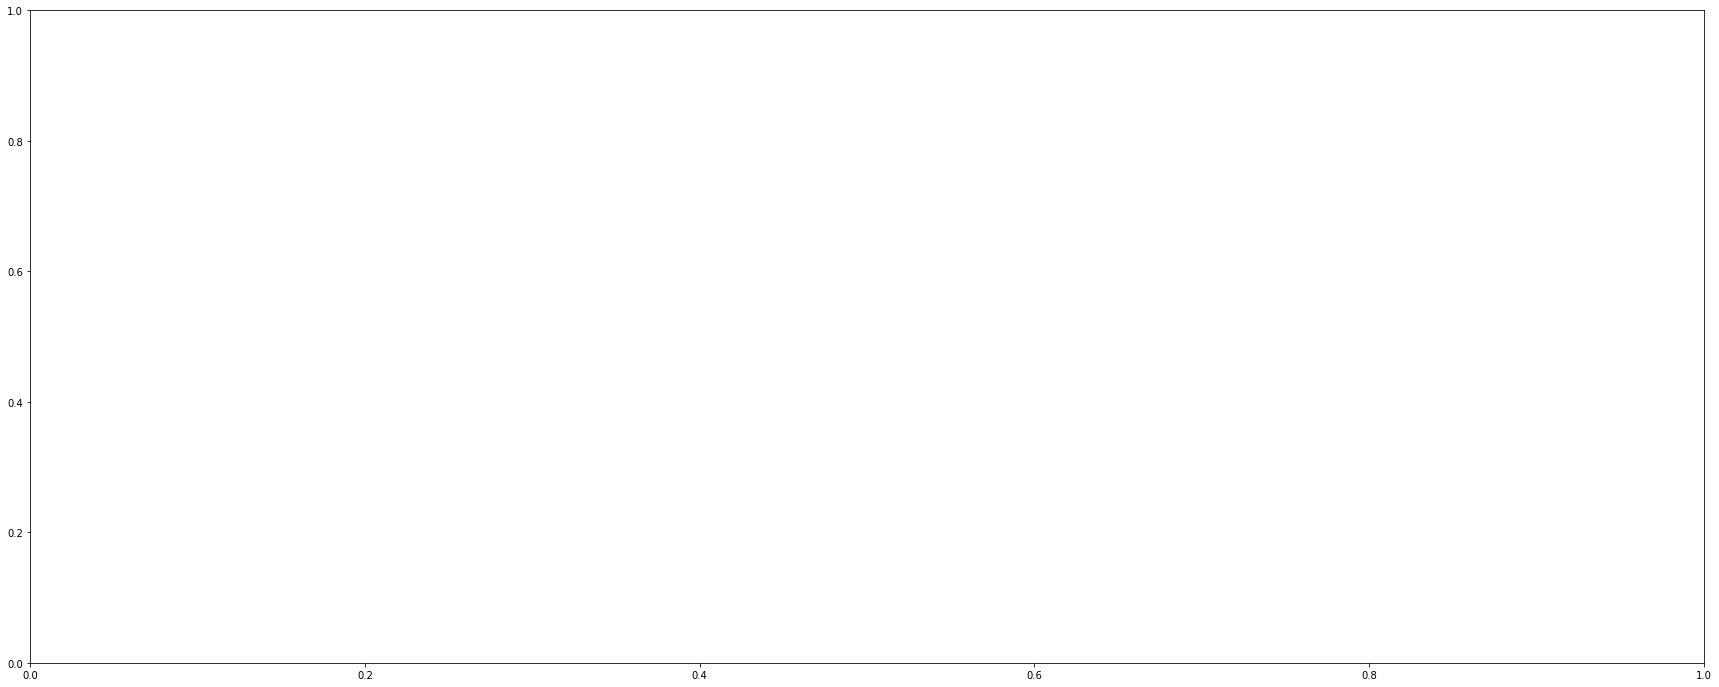

In [139]:
# Inspect initial results for ii
ii_stats = pd.DataFrame(index=range(len(chroms) * len(ii_enh_cutoff_values) * len(ii_enh_window_values) * len(repls) * len(compare_stats)), columns=["repl", "chrom", "cutoff", "window", "value", "stat", "tad_size", "amount"])
index = 0
for line in lines:
    for chrom in chroms:
        for cutoff in ii_enh_cutoff_values:
            for window in ii_enh_window_values:
                print(f"\rii_enh {line} {chrom}      ", end="")
                empty_1, empty_2 = False, False
                repl_1 = np.loadtxt(f"{out_location}ii_enh_{line}{1}.20000.chr{chrom}_window{window}_cutoff{cutoff}.txt", ndmin=2)
                repl_2 = np.loadtxt(f"{out_location}ii_enh_{line}{2}.20000.chr{chrom}_window{window}_cutoff{cutoff}.txt", ndmin=2)

                if repl_1.shape[0] == 0:
                    for stat in compare_stats:
                        ii_stats.loc[index, :] = [1, chrom, cutoff, window, 0, stat, 0, 0]
                        index += 1
                    empty_1 = True

                if repl_2.shape[0] == 0:
                    for stat in compare_stats:
                        ii_stats.loc[index, :] = [2, chrom, cutoff, window, 0, stat, 0, 0]
                        index += 1
                    empty_2 = True

                if empty_1 * empty_2:
                    continue

                elif empty_1:
                    size_2 = np.median(repl_2[:, 1] - repl_2[:, 0])
                    for stat in compare_stats:
                        ii_stats.loc[index, :] = [2, chrom, cutoff, window, 0, stat, size_2, repl_2.shape[0]]
                        index += 1
                    continue

                elif empty_2:
                    size_1 = np.median(repl_1[:, 1] - repl_1[:, 0])
                    for stat in compare_stats:
                        ii_stats.loc[index, :] = [1, chrom, cutoff, window, 0, stat, size_1, repl_1.shape[0]]
                        index += 1
                    continue

                coordinates = (repl_1[:, 0], repl_1[:, 1], repl_2[:, 0], repl_2[:, 1])
                size_amo = size_amount(repl_1, repl_2)
                for repl in repls:
                    for stat in compare_stats:
                        ii_stats.loc[index, :] = [repl, chrom, cutoff, window, coefs[stat](*coordinates), stat, size_amo[repl]["size"], size_amo[repl]["amount"]]
                        index += 1
    ii_stats["cutoff"] = np.array(ii_stats["cutoff"], dtype=float)
    ii_stats["window"] = np.array(ii_stats["window"], dtype=float)
    ii_stats["tad_size"] = np.array(ii_stats["tad_size"], dtype=float)
    ii_stats["amount"] = np.array(ii_stats["amount"], dtype=float)
    ii_stats["value"] = np.array(ii_stats["value"], dtype=float)               
    mpl.rcParams['figure.figsize'] = [30, 12]
    plt.subplot(231)
    sns.heatmap(data=ii_stats[ii_stats["stat"] == "JI TADs"].pivot_table(index=["window"], columns=["cutoff"], values="value"), center=0.5, linewidths=.5, vmin=0, vmax=1)
    plt.title("Insulation score: JI of TADs between two replica")
    plt.subplot(232)
    sns.heatmap(data=ii_stats[ii_stats["stat"] == "JI boundaries"].pivot_table(index=["window"], columns=["cutoff"], values="value"), center=0.5, linewidths=.5, vmin=0, vmax=1)
    plt.title("Insulation score: JI of boundaries between two replica")
    plt.subplot(233)
    sns.heatmap(data=ii_stats.pivot_table(index=["window"], columns=["cutoff"], values="tad_size"), center=1000000, linewidths=.5, vmin=0)
    plt.title("Insulation score: mean size of TADs")
    plt.subplot(234)
    sns.heatmap(data=ii_stats[ii_stats["stat"] == "OC TADs"].pivot_table(index=["window"], columns=["cutoff"], values="value"), center=0.5, linewidths=.5, vmin=0, vmax=1)
    plt.title("Insulation score: OC of TADs between two replica")
    plt.subplot(235)
    sns.heatmap(data=ii_stats[ii_stats["stat"] == "OC boundaries"].pivot_table(index=["window"], columns=["cutoff"], values="value"), center=0.5, linewidths=.5, vmin=0, vmax=1)
    plt.title("Insulation score: OC of boundaries between two replica")
    plt.subplot(236)
    sns.heatmap(data=ii_stats.pivot_table(index=["window"], columns=["cutoff"], values="amount"), center=500, linewidths=.5, vmin=0)
    plt.title("Insulation score: mean amount of TADs")
    plt.savefig(f"{images}ii_enh_{line}initial.png", bbox_inches='tight')
    plt.clf()
    plt.cla()

di HEK293_siRNA-CTCF_NA_ Y       

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_2.20000.chrY_window20000_cutoff5.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_2.20000.chrY_window40000_cutoff5.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_2.20000.chrY_window60000_cutoff5.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_2.20000.chrY_window80000_cutoff5.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_2.20000.chrY_window20000_cutoff6.txt"
  del sys.path[0]
C:\Us

di HEK293_siRNA-CTCF_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_1.20000.chrY_window40000_cutoff10.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_2.20000.chrY_window40000_cutoff10.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_1.20000.chrY_window60000_cutoff10.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_2.20000.chrY_window60000_cutoff10.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_1.20000.chrY_window80000_cutoff10.txt"
  if s

di HEK293_siRNA-CTCF_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_2.20000.chrY_window20000_cutoff15.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_1.20000.chrY_window40000_cutoff15.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_2.20000.chrY_window40000_cutoff15.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_1.20000.chrY_window60000_cutoff15.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-CTCF_NA_2.20000.chrY_window60000_cutoff15.txt"
  del 

di HEK293_siRNA-Control_NA_ Y       

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window20000_cutoff5.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window40000_cutoff5.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutoff5.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff5.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window200

di HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window40000_cutoff6.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutoff6.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff6.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window20000_cutoff7.txt"
  if sys.path[0] == '':


di HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window40000_cutoff7.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutoff7.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff7.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window20000_cutoff8.txt"
  if sys.path[0] == '':


di HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window40000_cutoff8.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutoff8.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff8.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window20000_cutoff9.txt"
  if sys.path[0] == '':


di HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window40000_cutoff9.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutoff9.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff9.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window20000_cutoff10.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_2.20000.chrY_window20

di HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window40000_cutoff10.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_2.20000.chrY_window40000_cutoff10.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutoff10.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_2.20000.chrY_window60000_cutoff10.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutof

di HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutoff11.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_2.20000.chrY_window60000_cutoff11.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff11.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_2.20000.chrY_window80000_cutoff11.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window20000_cutof

di HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window80000_cutoff12.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_2.20000.chrY_window80000_cutoff12.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window20000_cutoff13.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_2.20000.chrY_window20000_cutoff13.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window40000_cutof

di HEK293_siRNA-Control_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window20000_cutoff14.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_2.20000.chrY_window20000_cutoff14.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window40000_cutoff14.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_2.20000.chrY_window40000_cutoff14.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_HEK293_siRNA-Control_NA_1.20000.chrY_window60000_cutof

di RAD21cv-HEK293_HRV-treated_NA_ Y       

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window20000_cutoff6.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window40000_cutoff6.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff6.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window80000_cutoff6.txt"
  del sys.path[0]


di RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window20000_cutoff7.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window40000_cutoff7.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff7.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window80000_cutoff7.txt"
  del sys.path[0]


di RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window20000_cutoff8.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window20000_cutoff8.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window40000_cutoff8.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window40000_cutoff8.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20

di RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window20000_cutoff9.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window20000_cutoff9.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window40000_cutoff9.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window40000_cutoff9.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20

di RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window80000_cutoff9.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window80000_cutoff9.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window20000_cutoff10.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window20000_cutoff10.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.

di RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window60000_cutoff10.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff10.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window80000_cutoff10.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window80000_cutoff10.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_

di RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window40000_cutoff11.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window40000_cutoff11.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window60000_cutoff11.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff11.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_

di RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window40000_cutoff12.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window40000_cutoff12.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window60000_cutoff12.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff12.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_

di RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window40000_cutoff13.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window40000_cutoff13.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window60000_cutoff13.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff13.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_

di RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window40000_cutoff14.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window40000_cutoff14.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window60000_cutoff14.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff14.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_

di RAD21cv-HEK293_HRV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window40000_cutoff15.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window40000_cutoff15.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_1.20000.chrY_window60000_cutoff15.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_2.20000.chrY_window60000_cutoff15.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_HRV-treated_NA_

di RAD21cv-HEK293_TEV-treated_NA_ Y       

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window20000_cutoff5.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window40000_cutoff5.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window60000_cutoff5.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff5.txt"
  del sys.path[0]


di RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window20000_cutoff6.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window40000_cutoff6.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window60000_cutoff6.txt"
  del sys.path[0]


di RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff6.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window20000_cutoff7.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window20000_cutoff7.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window40000_cutoff7.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20

di RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff7.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff7.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window20000_cutoff8.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window20000_cutoff8.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20

di RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff8.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff8.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window20000_cutoff9.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window20000_cutoff9.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20

di RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff9.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff9.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window20000_cutoff10.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window20000_cutoff10.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.

di RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff10.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff10.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window20000_cutoff11.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window20000_cutoff11.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_

di RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff11.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff11.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window20000_cutoff12.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window20000_cutoff12.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_

di RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff12.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff12.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window20000_cutoff13.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window20000_cutoff13.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_

di RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff13.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff13.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window20000_cutoff14.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window20000_cutoff14.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_

di RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff14.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff14.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window20000_cutoff15.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window20000_cutoff15.txt"
  del sys.path[0]
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_

di RAD21cv-HEK293_TEV-treated_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_1.20000.chrY_window80000_cutoff15.txt"
  if sys.path[0] == '':
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: loadtxt: Empty input file: "yielded/di_RAD21cv-HEK293_TEV-treated_NA_2.20000.chrY_window80000_cutoff15.txt"
  del sys.path[0]


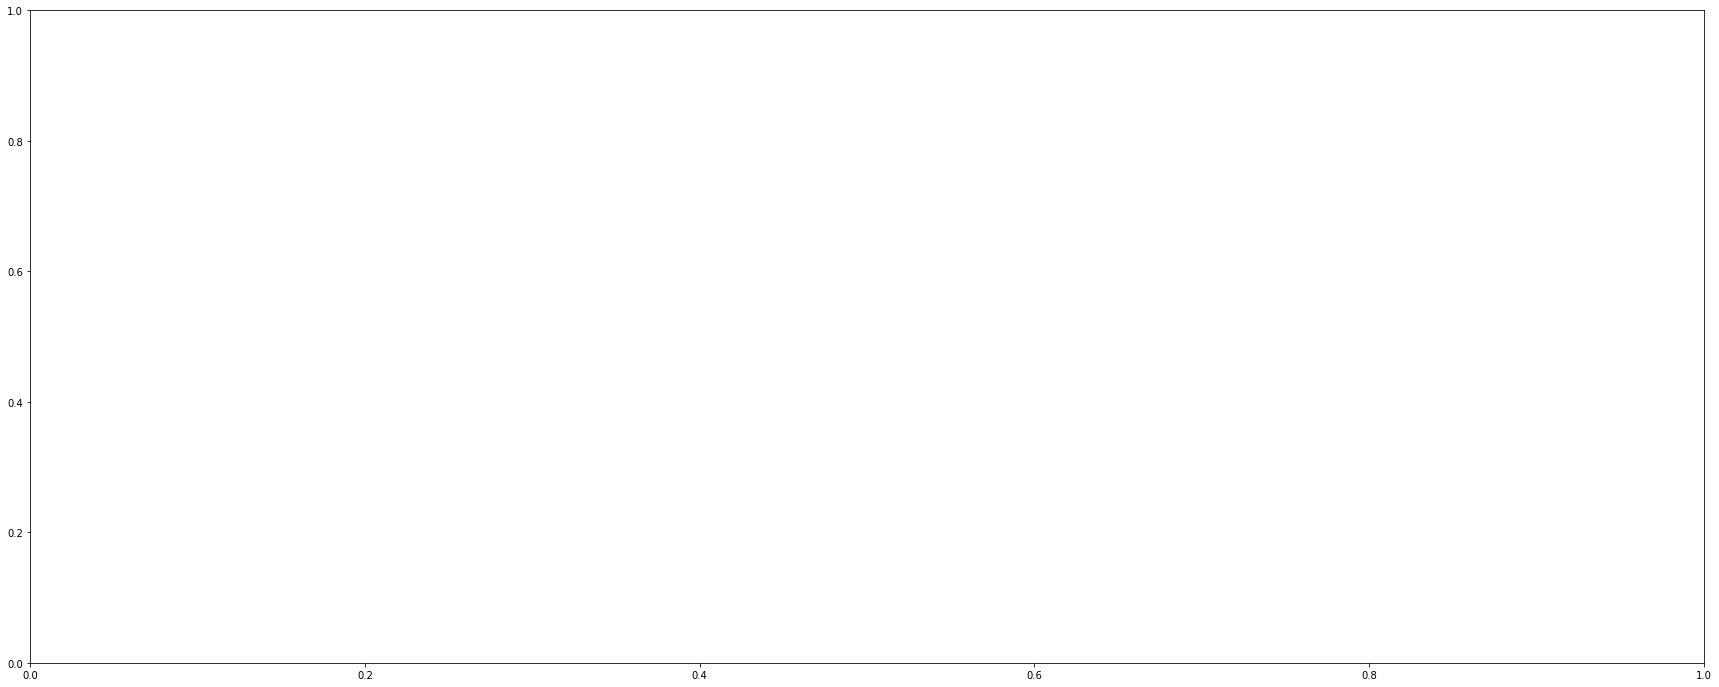

In [154]:
# Inspect initial results for di
di_stats = pd.DataFrame(index=range(len(chroms) * len(di_cutoff_values) * len(di_window_values) * len(repls) * len(compare_stats)), columns=["repl", "chrom", "cutoff", "window", "value", "stat", "tad_size", "amount"])
index = 0
for line in lines:
    for chrom in chroms:
        for cutoff in di_cutoff_values:
            for window in di_window_values:
                if line == "A549_NA_NA_":
                    continue
                print(f"\rdi {line} {chrom}      ", end="")
                empty_1, empty_2 = False, False
                repl_1 = np.loadtxt(f"{out_location}di_{line}{1}.20000.chr{chrom}_window{window}_cutoff{cutoff}.txt", ndmin=2)
                repl_2 = np.loadtxt(f"{out_location}di_{line}{2}.20000.chr{chrom}_window{window}_cutoff{cutoff}.txt", ndmin=2)

                if repl_1.shape[0] == 0:
                    for stat in compare_stats:
                        di_stats.loc[index, :] = [1, chrom, cutoff, window, 0, stat, 0, 0]
                        index += 1
                    empty_1 = True

                if repl_2.shape[0] == 0:
                    for stat in compare_stats:
                        di_stats.loc[index, :] = [2, chrom, cutoff, window, 0, stat, 0, 0]
                        index += 1
                    empty_2 = True

                if empty_1 * empty_2:
                    continue

                elif empty_1:
                    size_2 = np.median(repl_2[:, 1] - repl_2[:, 0])
                    for stat in compare_stats:
                        di_stats.loc[index, :] = [2, chrom, cutoff, window, 0, stat, size_2, repl_2.shape[0]]
                        index += 1
                    continue

                elif empty_2:
                    size_1 = np.median(repl_1[:, 1] - repl_1[:, 0])
                    for stat in compare_stats:
                        di_stats.loc[index, :] = [1, chrom, cutoff, window, 0, stat, size_1, repl_1.shape[0]]
                        index += 1
                    continue

                coordinates = (repl_1[:, 0], repl_1[:, 1], repl_2[:, 0], repl_2[:, 1])
                size_amo = size_amount(repl_1, repl_2)
                for repl in repls:
                    for stat in compare_stats:
                        di_stats.loc[index, :] = [repl, chrom, cutoff, window, coefs[stat](*coordinates), stat, size_amo[repl]["size"], size_amo[repl]["amount"]]
                        index += 1
    if line == "A549_NA_NA_":
        continue
    di_stats["cutoff"] = np.array(di_stats["cutoff"], dtype=float)
    di_stats["window"] = np.array(di_stats["window"], dtype=float)
    di_stats["tad_size"] = np.array(di_stats["tad_size"], dtype=float)
    di_stats["amount"] = np.array(di_stats["amount"], dtype=float)
    di_stats["value"] = np.array(di_stats["value"], dtype=float)               
    mpl.rcParams['figure.figsize'] = [30, 12]
    plt.subplot(231)
    sns.heatmap(data=di_stats[di_stats["stat"] == "JI TADs"].pivot_table(index=["window"], columns=["cutoff"], values="value"), center=0.5, linewidths=.5, vmin=0, vmax=1)
    plt.title("Directionality index: JI of TADs between two replica")
    plt.subplot(232)
    sns.heatmap(data=di_stats[di_stats["stat"] == "JI boundaries"].pivot_table(index=["window"], columns=["cutoff"], values="value"), center=0.5, linewidths=.5, vmin=0, vmax=1)
    plt.title("Directionality index: JI of boundaries between two replica")
    plt.subplot(233)
    sns.heatmap(data=di_stats.pivot_table(index=["window"], columns=["cutoff"], values="tad_size"), center=1700000, linewidths=.5, vmin=0)
    plt.title("Directionality index: mean size of TADs")
    plt.subplot(234)
    sns.heatmap(data=di_stats[di_stats["stat"] == "OC TADs"].pivot_table(index=["window"], columns=["cutoff"], values="value"), center=0.5, linewidths=.5, vmin=0, vmax=1)
    plt.title("Directionality index: OC of TADs between two replica")
    plt.subplot(235)
    sns.heatmap(data=di_stats[di_stats["stat"] == "OC boundaries"].pivot_table(index=["window"], columns=["cutoff"], values="value"), center=0.5, linewidths=.5, vmin=0, vmax=1)
    plt.title("Directionality index: OC of boundaries between two replica")
    plt.subplot(236)
    sns.heatmap(data=di_stats.pivot_table(index=["window"], columns=["cutoff"], values="amount"), center=500, linewidths=.5, vmin=0)
    plt.title("Directionality index: mean amount of TADs")
    plt.savefig(f"{images}di_1{line}initial.png", bbox_inches='tight')
    plt.clf()
    plt.cla()

hicseg A549_NA_NA_ Y      

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: loadtxt: Empty input file: "yielded/hicseg_A549_NA_NA_1.20000.chr22.txt"
  import sys
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: loadtxt: Empty input file: "yielded/hicseg_A549_NA_NA_2.20000.chr22.txt"
  


hicseg HEK293_siRNA-CTCF_NA_ Y       

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: loadtxt: Empty input file: "yielded/hicseg_HEK293_siRNA-CTCF_NA_1.20000.chr22.txt"
  import sys
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: loadtxt: Empty input file: "yielded/hicseg_HEK293_siRNA-CTCF_NA_2.20000.chr22.txt"
  


hicseg HEK293_siRNA-Control_NA_ Y       

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: loadtxt: Empty input file: "yielded/hicseg_HEK293_siRNA-Control_NA_1.20000.chr22.txt"
  import sys
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: loadtxt: Empty input file: "yielded/hicseg_HEK293_siRNA-Control_NA_2.20000.chr22.txt"
  


hicseg HepG2_NA_NA_ Y       

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: loadtxt: Empty input file: "yielded/hicseg_HepG2_NA_NA_1.20000.chr22.txt"
  import sys
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: loadtxt: Empty input file: "yielded/hicseg_HepG2_NA_NA_2.20000.chr22.txt"
  


hicseg RAD21cv-HEK293_HRV-treated_NA_ Y       

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: loadtxt: Empty input file: "yielded/hicseg_RAD21cv-HEK293_HRV-treated_NA_1.20000.chr22.txt"
  import sys
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: loadtxt: Empty input file: "yielded/hicseg_RAD21cv-HEK293_HRV-treated_NA_2.20000.chr22.txt"
  


hicseg RAD21cv-HEK293_TEV-treated_NA_ Y       

C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: loadtxt: Empty input file: "yielded/hicseg_RAD21cv-HEK293_TEV-treated_NA_1.20000.chr22.txt"
  import sys
C:\Users\Dmitry\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: loadtxt: Empty input file: "yielded/hicseg_RAD21cv-HEK293_TEV-treated_NA_2.20000.chr22.txt"
  


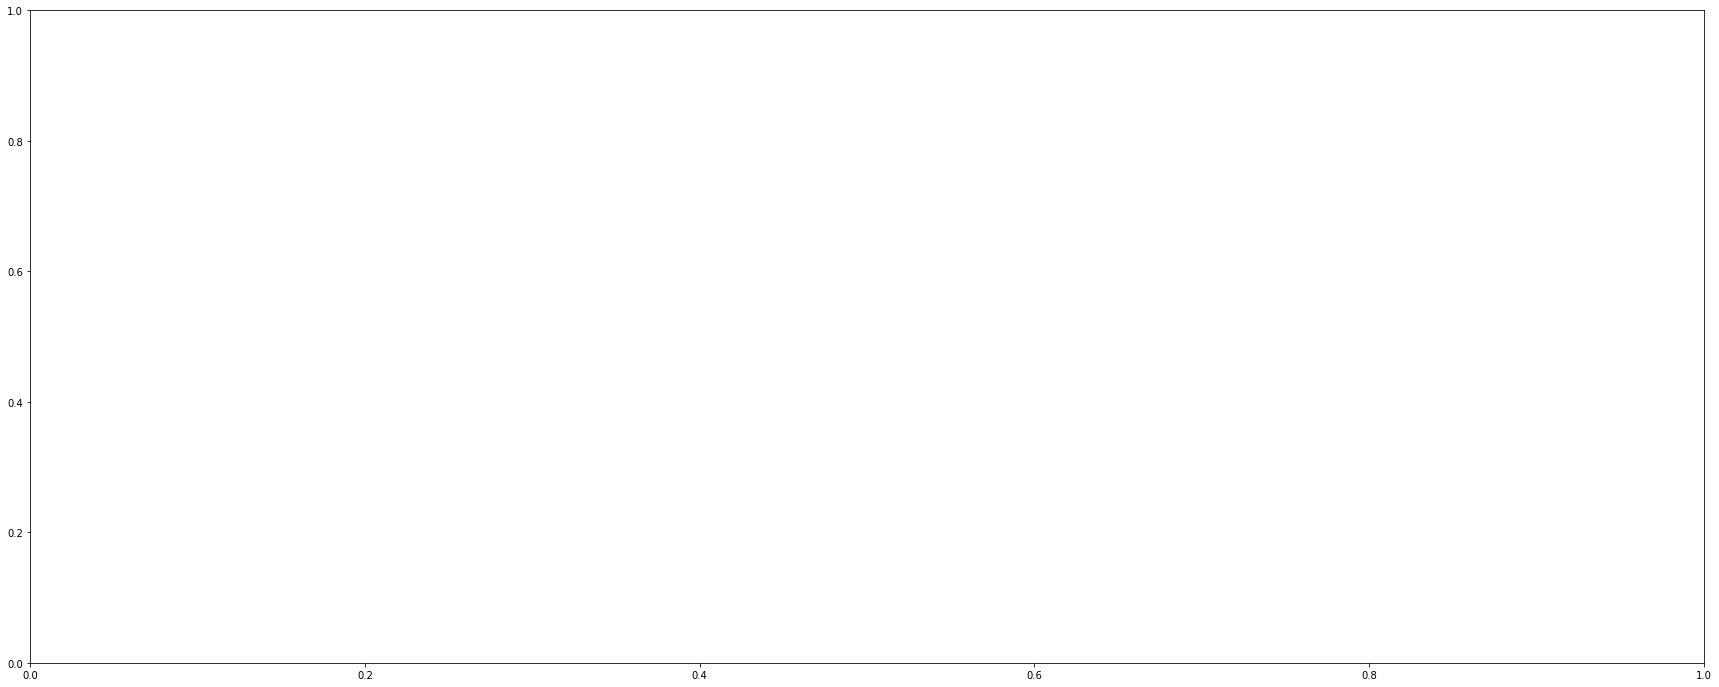

In [137]:
hicseg_stats = pd.DataFrame(index=range(len(chroms) * len(repls) * len(compare_stats)), columns=["repl", "chrom", "value", "stat", "tad_size", "amount"])
index = 0
for line in lines:
    for chrom in chroms:
        print(f"\rhicseg {line} {chrom}      ", end="")
        empty_1, empty_2 = False, False
        repl_1 = np.loadtxt(f"{out_location}hicseg_{line}{1}.20000.chr{chrom}.txt", ndmin=2)
        repl_2 = np.loadtxt(f"{out_location}hicseg_{line}{2}.20000.chr{chrom}.txt", ndmin=2)

        if repl_1.shape[0] == 0:
            for stat in compare_stats:
                hicseg_stats.loc[index, :] = [1, chrom, 0, stat, 0, 0]
                index += 1
            empty_1 = True

        if repl_2.shape[0] == 0:
            for stat in compare_stats:
                hicseg_stats.loc[index, :] = [2, chrom, 0, stat, 0, 0]
                index += 1
            empty_2 = True

        if empty_1 * empty_2:
            continue

        elif empty_1:
            size_2 = np.median(repl_2[:, 1] - repl_2[:, 0])
            for stat in compare_stats:
                hicseg_stats.loc[index, :] = [2, chrom, 0, stat, size_2, repl_2.shape[0]]
                index += 1
            continue

        elif empty_2:
            size_1 = np.median(repl_1[:, 1] - repl_1[:, 0])
            for stat in compare_stats:
                hicseg_stats.loc[index, :] = [1, chrom, 0, stat, size_1, repl_1.shape[0]]
                index += 1
            continue

        coordinates = (repl_1[:, 0], repl_1[:, 1], repl_2[:, 0], repl_2[:, 1])
        size_amo = size_amount(repl_1, repl_2)
        for repl in repls:
            for stat in compare_stats:
                hicseg_stats.loc[index, :] = [repl, window, coefs[stat](*coordinates), stat, size_amo[repl]["size"], size_amo[repl]["amount"]]
                index += 1
    mpl.rcParams['figure.figsize'] = [30, 12]
    plt.subplot(231)
    sns.kdeplot(di_stats["value"][di_stats["stat"] == "JI TADs"], shade=True, color="blue")
    plt.title("HiCseg: JI of TADs between two replica")
    plt.subplot(232)
    sns.kdeplot(di_stats["value"][di_stats["stat"] == "JI boundaries"], shade=True, color="green")
    plt.title("HiCseg: JI of boundaries between two replica")
    plt.subplot(233)
    sns.kdeplot(di_stats["tad_size"][di_stats["repl"] == 1], di_stats["tad_size"][di_stats["repl"] == 2], shade=True)
    plt.title("HiCseg: mean size of TADs")
    plt.xlim(0, 1000000)
    plt.ylim(0, 1000000)
    plt.subplot(234)
    sns.kdeplot(di_stats["value"][di_stats["stat"] == "OC TADs"], shade=True, color="red")
    plt.title("HiCseg: OC of TADs between two replica")
    plt.subplot(235)
    sns.kdeplot(di_stats["value"][di_stats["stat"] == "OC boundaries"], shade=True, color="purple")
    plt.title("HiCseg: OC of boundaries between two replica")
    plt.subplot(236)
    sns.kdeplot(di_stats["amount"][di_stats["repl"] == 1], di_stats["amount"][di_stats["repl"] == 2], shade=True)
    plt.title("HiCseg: amount of TADs")
    plt.xlim(0, 200)
    plt.ylim(0, 200)
    plt.savefig(f"{images}hicseg_{line}initial.png", bbox_inches='tight')
    plt.clf()
    plt.cla()

In [187]:
ideals = [lava_armatus_stats[(lava_armatus_stats["gamma"] <= 0) & (-1.5 <= lava_armatus_stats["gamma"])].loc[:, ["value", "stat", "tad_size", "amount"]],
          armatus_stats[(armatus_stats["gamma"] <= 0.5) & (-0.5 <= armatus_stats["gamma"])].loc[:, ["value", "stat", "tad_size", "amount"]],
          modularity_stats[modularity_stats["gamma"] == 1].loc[:, ["value", "stat", "tad_size", "amount"]],
          corner_stats[corner_stats["gamma"] == 2].loc[:, ["value", "stat", "tad_size", "amount"]],
          hicseg_stats.loc[:, ["value", "stat", "tad_size", "amount"]],
          ii_stats[(ii_stats["cutoff"] == 1) & (ii_stats["window"] == 40000)].loc[:, ["value", "stat", "tad_size", "amount"]],
          di_stats[(di_stats["cutoff"] == 8) & (di_stats["window"] == 60000)].loc[:, ["value", "stat", "tad_size", "amount"]]
         ]

In [196]:
size = sum([i.shape[0] for i in ideals])
ideal_stats = pd.DataFrame(index=range(size), columns=["method", "value", "stat", "tad_size", "amount"])
methods = ["Armatus\nlavaburst", "Armatus\nstandalone", "Modularity", "Corner", "HiCseg", "Insulation\nScore", "Directionality\nindex"]
start = 0
i = 0
for method in ideals:
    end = start + method.shape[0] - 1
    ideal_stats.loc[start:end, "value":] = np.array(method, dtype=object)
    ideal_stats.loc[start:end, "method"] = methods[i]
    start += method.shape[0]
    i += 1
ideal_stats["amount"] = np.array(ideal_stats["amount"], dtype=float)
ideal_stats["value"] = np.array(ideal_stats["value"], dtype=float)

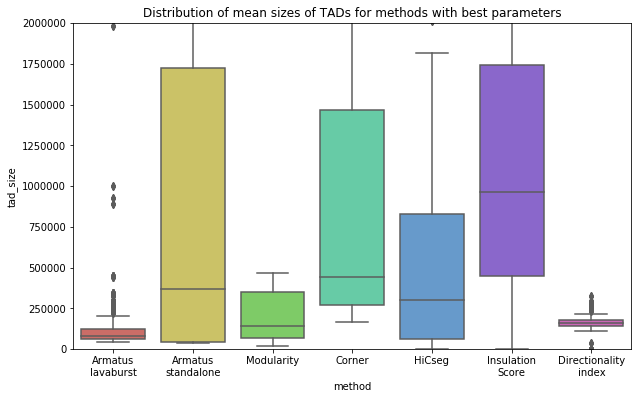

In [237]:
ideal_stats["tad_size"] = np.array(ideal_stats["tad_size"], dtype=float)
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("hls", 7))
sns.boxplot(data=ideal_stats, x="method", y="tad_size")
plt.title("Distribution of mean sizes of TADs for methods with best parameters")
plt.ylim(0, 2000000)
plt.savefig(f"{images}sizes_best_all.png")

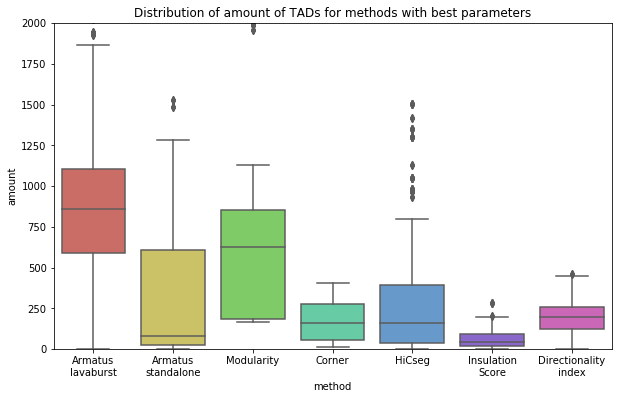

In [230]:
mpl.rcParams['figure.figsize'] = [10, 6]
sns.set_palette(sns.color_palette("hls", 7))
sns.boxplot(data=ideal_stats, x="method", y="amount")
plt.title("Distribution of amount of TADs for methods with best parameters")
plt.ylim(0, 2000)
plt.savefig(f"{images}amounts_best_all.png")

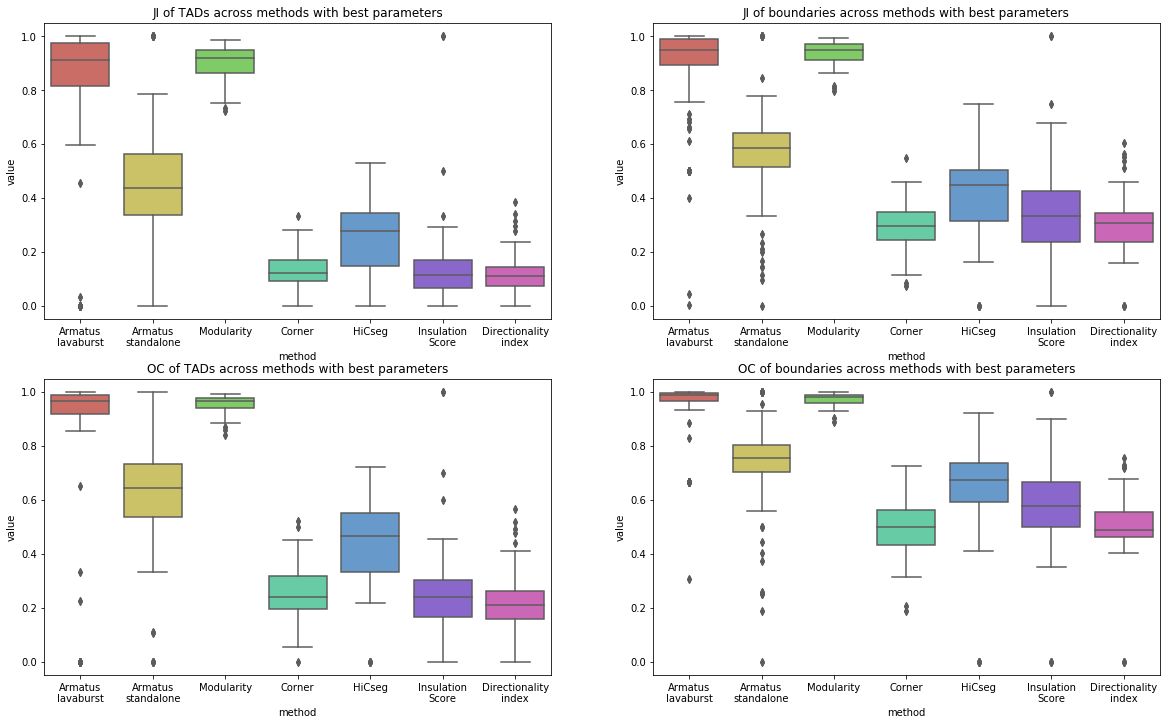

In [227]:
mpl.rcParams['figure.figsize'] = [20, 12]
sns.set_palette(sns.color_palette("hls", 7))
plt.subplot(221)
sns.boxplot(data=ideal_stats[ideal_stats["stat"] == "JI TADs"], x="method", y="value")
plt.title("JI of TADs across methods with best parameters")
plt.subplot(222)
sns.boxplot(data=ideal_stats[ideal_stats["stat"] == "JI boundaries"], x="method", y="value")
plt.title("JI of boundaries across methods with best parameters")
plt.subplot(223)
sns.boxplot(data=ideal_stats[ideal_stats["stat"] == "OC TADs"], x="method", y="value")
plt.title("OC of TADs across methods with best parameters")
plt.subplot(224)
sns.boxplot(data=ideal_stats[ideal_stats["stat"] == "OC boundaries"], x="method", y="value")
plt.title("OC of boundaries across methods with best parameters")
plt.savefig(f"{images}stats_best_all.png")